# Multiple mode response to Zeeman field

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from scipy import optimize
import logging
import cPickle as pickle
import kwant
import dolfin
import electrostatics as estat
import generate_system
logging.getLogger('FFC').setLevel(logging.WARNING)

In [3]:
"""Set system dimensions and constants, build the system"""

hbar = 1.055e-34
m = 9.109e-31
meff = 0.014*m
akwant, aFEM = 2.5e-9, 5e-9
eV, e = 1.6023e-19, 1.6023e-19
eps0 = 8.854e-12
gamma=hbar**2/(2*meff*akwant**2)
energy_par = estat.EnergyParameters(akwant=akwant, eps_dielec=8.0, eps_wire=17.7, 
                                    gamma=hbar**2/(2*meff*akwant**2), scaler=eV/gamma, 
                                    bandgap=0.1, Delta=0.5e-3, 
                                    poisson_scale=e*aFEM**2/(akwant**3*eps0),
                                    miliscaler = 1000*gamma/eV)

dimension_par = estat.DimensionParameters(radius=50e-9/aFEM, top=250e-9/aFEM, 
                                          top_sc=187e-9/aFEM - 10*np.sin(np.pi/3.0),
                                          side=300e-9/aFEM, dielec_thickness=30e-9/aFEM)
solver_kwargs = {'alpha': 0.5, 'M': 5, 'verbose': 0, 'f_tol': 1e-7, 'maxiter': 200} 

sys = generate_system.kwant_hexagonal_nanowire(energy_par, dimension_par, a=0.5)
site_pos = np.array([sys.site(i).pos for i in xrange(sys.graph.num_nodes)])
mesh, mesh_points, length, length_wire = generate_system.mesh_hexagonal_nanowire(dimension_par)[:4]
V = dolfin.FunctionSpace(mesh, 'Lagrange', 1)
discr_par = estat.DiscretizationParameters(sys=sys, site_pos=site_pos, mesh=mesh, 
                                           mesh_points=mesh_points, length=length, 
                                           length_wire=length_wire, V=V)

Ez_range = np.arange(0.0e-3*eV/gamma, 7.3e-3*eV/gamma, 0.01e-3*eV/gamma)

V_G_N1 = {'No SC': 0.112, '0.0, 233': 0.3011, '0.2, 233': -0.91, '0.0, 100': 0.3042, \
          '0.2, 100': -0.903, '0.0, 60': 0.3085, '0.2, 60': -0.893}
V_G_N3 = {'No SC': 0.178, '0.0, 233': 0.525, '0.2, 233': -0.156, '0.0, 100': 0.53, \
          '0.2, 100': -0.1515, '0.0, 60': 0.5365, '0.2, 60': -0.1453}
V_G_N10 = {'No SC': 0.741, '0.0, 233': 1.47, '0.2, 233': 0.571, '0.0, 100': 1.475, \
          '0.2, 100': 0.577, '0.0, 60': 1.484, '0.2, 60': 0.586}

## One mode in the wire

In [4]:
V_G_dict = V_G_N1

environment_parameters = [{'V_G': V_G_dict['No SC'], 'V_SC': 'No SC', 'l_SO': 233e-9, 'tag': 'No SC'},
                          {'V_G': V_G_dict['0.0, 233'], 'V_SC': 0.0, 'l_SO': 233e-9, 'tag': '0V, 233nm'},
                          {'V_G': V_G_dict['0.2, 233'], 'V_SC': 0.2, 'l_SO': 233e-9, 'tag': '02V, 233nm'},
                          {'V_G': V_G_dict['0.0, 100'], 'V_SC': 0.0, 'l_SO': 100e-9, 'tag': '0V, 100nm'},
                          {'V_G': V_G_dict['0.2, 100'], 'V_SC': 0.2, 'l_SO': 100e-9, 'tag': '02V, 100nm'},
                          {'V_G': V_G_dict['0.0, 60'], 'V_SC': 0.0, 'l_SO': 60e-9, 'tag': '0V, 60nm'},
                          {'V_G': V_G_dict['0.2, 60'], 'V_SC': 0.2, 'l_SO': 60e-9, 'tag': '02V, 60nm'}]

mu_pert_dict_N1 = {}
init_sol = []

for environment in environment_parameters:
    V_G = environment['V_G']
    V_SC = environment['V_SC']
    l_SO = environment['l_SO']
    alpha = energy_par.akwant/l_SO
    initial_guess = 0.06*np.ones(discr_par.length)
    sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
    perturbations, mu0, wave_modes, densities, sp_sol, energies =\
    estat.init_field_simulation(0e-3*eV/gamma, initial_guess, sigma, l_SO, V_G, V_SC,
                                generate_system.potential, solver_kwargs, energy_par, 
                                dimension_par, discr_par)[:6]
    dmu_init = np.zeros(len(energies))
    wf0 = wave_modes[-1]
    n0 = densities[-1]
    mu_pert_list = []

    for Ez in Ez_range:
        mu_pert, A, alpha_func, dn = estat.self_consistent_mu(wave_modes, energies, 
                                                              densities, perturbations,
                                                              Ez, l_SO, dmu_init, V_G, 
                                                              energy_par)[0:4]
        dmu_init = mu_pert
        mu_pert_list.append(mu0 - mu_pert[-1])
    mu_pert_dict_N1[environment['tag']] = mu_pert_list

## Three modes in the wire

In [5]:
V_G_dict = V_G_N3

environment_parameters = [{'V_G': V_G_dict['No SC'], 'V_SC': 'No SC', 'l_SO': 233e-9, 'tag': 'No SC'},
                          {'V_G': V_G_dict['0.0, 233'], 'V_SC': 0.0, 'l_SO': 233e-9, 'tag': '0V, 233nm'},
                          {'V_G': V_G_dict['0.2, 233'], 'V_SC': 0.2, 'l_SO': 233e-9, 'tag': '02V, 233nm'},
                          {'V_G': V_G_dict['0.0, 100'], 'V_SC': 0.0, 'l_SO': 100e-9, 'tag': '0V, 100nm'},
                          {'V_G': V_G_dict['0.2, 100'], 'V_SC': 0.2, 'l_SO': 100e-9, 'tag': '02V, 100nm'},
                          {'V_G': V_G_dict['0.0, 60'], 'V_SC': 0.0, 'l_SO': 60e-9, 'tag': '0V, 60nm'},
                          {'V_G': V_G_dict['0.2, 60'], 'V_SC': 0.2, 'l_SO': 60e-9, 'tag': '02V, 60nm'}]

mu_pert_dict_N3 = {}
init_sol = []

for environment in environment_parameters:
    V_G = environment['V_G']
    V_SC = environment['V_SC']
    l_SO = environment['l_SO']
    alpha = energy_par.akwant/l_SO
    initial_guess = 0.06*np.ones(discr_par.length)
    sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
    perturbations, mu0, wave_modes, densities, sp_sol, energies =\
    estat.init_field_simulation(0e-3*eV/gamma, initial_guess, sigma, l_SO, V_G, V_SC,
                                generate_system.potential, solver_kwargs, energy_par, 
                                dimension_par, discr_par)[:6]
    dmu_init = np.zeros(len(energies))
    wf0 = wave_modes[-1]
    n0 = densities[-1]
    mu_pert_list = []

    for Ez in Ez_range:
        mu_pert, A, alpha_func, dn = estat.self_consistent_mu(wave_modes, energies, 
                                                              densities, perturbations,
                                                              Ez, l_SO, dmu_init, V_G, 
                                                              energy_par)[0:4]
        dmu_init = mu_pert
        mu_pert_list.append(mu0 - mu_pert[-1])
    mu_pert_dict_N3[environment['tag']] = mu_pert_list

## Ten modes in the wire

In [6]:

V_G_dict = V_G_N10

environment_parameters = [{'V_G': V_G_dict['No SC'], 'V_SC': 'No SC', 'l_SO': 233e-9, 'tag': 'No SC'},
                          {'V_G': V_G_dict['0.0, 233'], 'V_SC': 0.0, 'l_SO': 233e-9, 'tag': '0V, 233nm'},
                          {'V_G': V_G_dict['0.2, 233'], 'V_SC': 0.2, 'l_SO': 233e-9, 'tag': '02V, 233nm'},
                          {'V_G': V_G_dict['0.0, 100'], 'V_SC': 0.0, 'l_SO': 100e-9, 'tag': '0V, 100nm'},
                          {'V_G': V_G_dict['0.2, 100'], 'V_SC': 0.2, 'l_SO': 100e-9, 'tag': '02V, 100nm'},
                          {'V_G': V_G_dict['0.0, 60'], 'V_SC': 0.0, 'l_SO': 60e-9, 'tag': '0V, 60nm'},
                          {'V_G': V_G_dict['0.2, 60'], 'V_SC': 0.2, 'l_SO': 60e-9, 'tag': '02V, 60nm'}]

mu_pert_dict_N10 = {}
init_sol = []

for environment in environment_parameters:
    V_G = environment['V_G']
    V_SC = environment['V_SC']
    l_SO = environment['l_SO']
    alpha = energy_par.akwant/l_SO
    initial_guess = 0.06*np.ones(discr_par.length)
    sigma = estat.energy_lowerbound(V_G, V_SC, energy_par)
    perturbations, mu0, wave_modes, densities, sp_sol, energies =\
    estat.init_field_simulation(0e-3*eV/gamma, initial_guess, sigma, l_SO, V_G, V_SC, 
                                generate_system.potential, solver_kwargs, energy_par, 
                                dimension_par, discr_par)[:6]
    dmu_init = np.zeros(len(energies))
    wf0 = wave_modes[-1]
    n0 = densities[-1]
    mu_pert_list = []

    for Ez in Ez_range:
        mu_pert, A, alpha_func, dn = estat.self_consistent_mu(wave_modes, energies, 
                                                              densities, perturbations,
                                                              Ez, l_SO, dmu_init, V_G, 
                                                              energy_par)[0:4]
        dmu_init = mu_pert
        mu_pert_list.append(mu0 - mu_pert[-1])
    mu_pert_dict_N10[environment['tag']] = mu_pert_list

(array([-3., -2., -1.,  0.,  1.]), <a list of 5 Text yticklabel objects>)

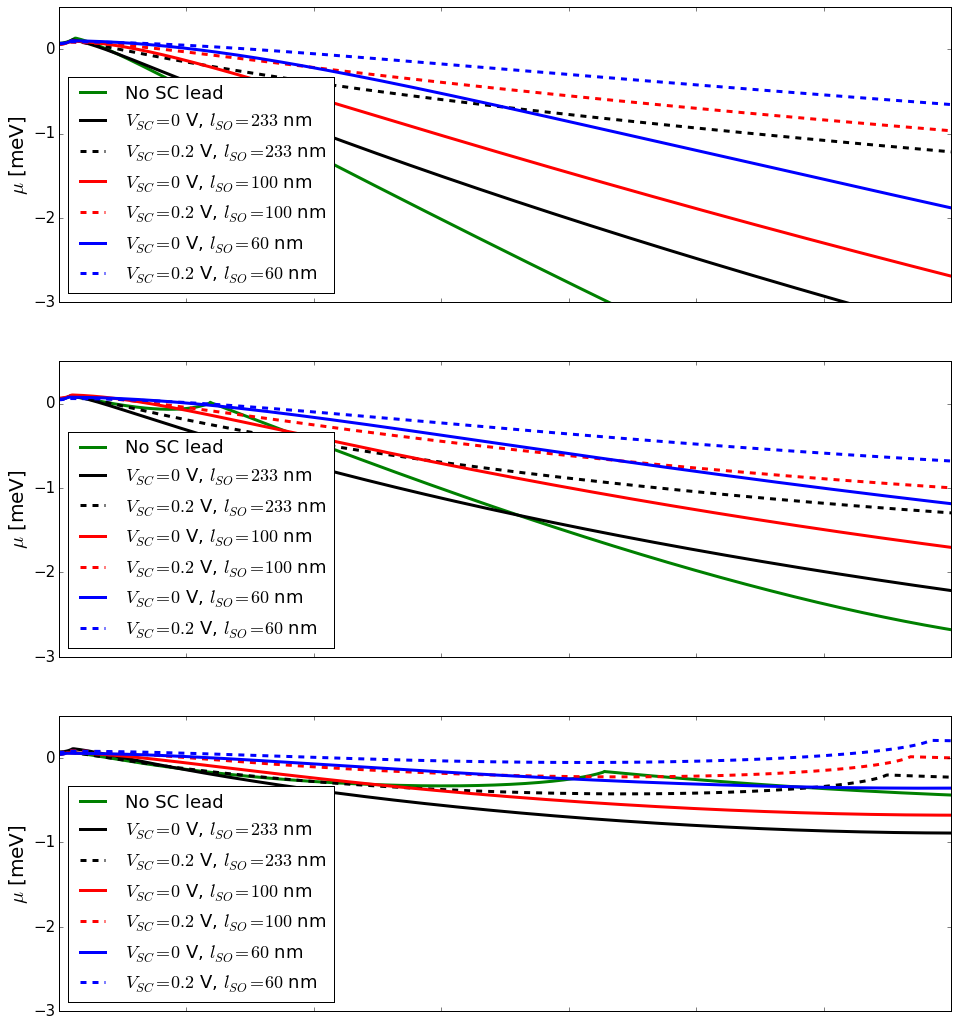

In [8]:
kw_str = ['No SC', '0V, 233nm', '02V, 233nm', '0V, 100nm', '02V, 100nm', '0V, 60nm', '02V, 60nm']
title_str = ['No SC lead', '$V_{SC} = 0$ V, $l_{SO} = 233$ nm', '$V_{SC} = 0.2$ V, $l_{SO} = 233$ nm',\
             '$V_{SC} = 0$ V, $l_{SO} = 100$ nm', '$V_{SC} = 0.2$ V, $l_{SO} = 100$ nm',\
             '$V_{SC} = 0$ V, $l_{SO} = 60$ nm','$V_{SC} = 0.2$ V, $l_{SO} = 60$ nm']
clr_str = ['g-', 'k-', 'k--', 'r-', 'r--', 'b-', 'b--']

Ez_range_scaled = [1000*gamma/eV*a for a in Ez_range]

fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(3, 1, 1)
ax1.hold(True)
for i, kw in enumerate(kw_str):
    mu_pert_arr_scaled = 1000*gamma/eV*np.array(mu_pert_dict_N1[kw])
    ax1.plot(Ez_range_scaled, mu_pert_arr_scaled, clr_str[i], label=title_str[i], lw=3)
ax1.set_ylabel('$\mu$ [meV]', fontsize=20)
ax1.legend(loc='lower left', ncol=1, fontsize=18)
ax1.locator_params(axis = 'y', nbins=6)
plb.setp(ax1.get_xticklabels(), visible=False)
ax1.set_xlim(0, 7)
ax1.set_ylim(-3, 0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax2 = fig.add_subplot(3, 1, 2)
ax2.hold(True)
for i, kw in enumerate(kw_str):
    mu_pert_arr_scaled = 1000*gamma/eV*np.array(mu_pert_dict_N3[kw])
    ax2.plot(Ez_range_scaled, mu_pert_arr_scaled, clr_str[i], label=title_str[i], lw=3)
ax2.set_ylabel('$\mu$ [meV]', fontsize=20)
ax2.legend(loc='lower left', ncol=1, fontsize=18)
ax2.locator_params(axis = 'y', nbins=6)
plb.setp(ax2.get_xticklabels(), visible=False)
ax2.set_xlim(0, 7)
ax2.set_ylim(-3, 0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

ax3 = fig.add_subplot(3, 1, 3)
ax3.hold(True)
for i, kw in enumerate(kw_str):
    mu_pert_arr_scaled = 1000*gamma/eV*np.array(mu_pert_dict_N10[kw])
    ax3.plot(Ez_range_scaled, mu_pert_arr_scaled, clr_str[i], label=title_str[i], lw=3)
ax3.set_ylabel('$\mu$ [meV]', fontsize=20)
ax3.legend(loc='lower left', ncol=1, fontsize=18)
ax3.locator_params(axis = 'y', nbins=6)
plb.setp(ax3.get_xticklabels(), visible=False)
ax3.set_xlim(0, 7)
ax3.set_ylim(-3, 0.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [9]:
with open("data_mu_multiple_bands.p", 'wb') as fp:
    pickle.dump(Ez_range, fp)
    pickle.dump(mu_pert_dict_N1, fp)
    pickle.dump(mu_pert_dict_N3, fp)
    pickle.dump(mu_pert_dict_N10, fp)